In [1]:
using DataFrames
using Plots
using CategoricalArrays
using Random
using Imbalance
using MLJBase: machine, transform
using ScientificTypes
using TableTransforms
using CSV
using DataFrames

### 1. Generate Random Data

In [2]:
rng = Random.default_rng()


num_rows = 100
num_cont_feats = 0
probs = [0.5, 0.2, 0.3]

cat_feats_num_vals = [3, 4, 2, 5]

X, y = generate_imbalanced_data(num_rows, num_cont_feats; probs, cat_feats_num_vals)
X = DataFrame(X)

X = coerce(X, autotype(X, :few_to_finite))

Row,Column1,Column2,Column3,Column4
,Cat…,Cat…,Cat…,Cat…
1,1,4,2,1
2,2,1,1,2
3,3,3,2,4
4,2,4,1,3
5,3,1,1,2
6,2,3,2,4
7,1,2,2,2
8,2,1,1,5
9,2,4,1,5


### 2. Apply SMOTE-N

#### Using Imbalance Only

In [3]:
Xover, yover = smoten(X, y; k = 5, ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng = 42)

Matrix{

UInt32}
LinearAlgebra.Transpose{UInt32, Matrix{UInt32}}
Matrix

{Float32}
Matrix{Float32}


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01



Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  class:  2


Matrix{Float32}
Matrix{Float32}


(192×4 DataFrame
 Row │ Column1  Column2  Column3  Column4 
     │ Cat…     Cat…     Cat…     Cat…    
─────┼────────────────────────────────────
   1 │ 1        4        2        1
   2 │ 2        1        1        2
   3 │ 3        3        2        4
   4 │ 2        4        1        3
   5 │ 3        1        1        2
   6 │ 2        3        2        4
   7 │ 1        2        2        2
   8 │ 2        1        1        5
  ⋮  │    ⋮        ⋮        ⋮        ⋮
 186 │ 3        4        1        2
 187 │ 2        4        2        5
 188 │ 2        1        1        3
 189 │ 3        3        1        2
 190 │ 3        3        1        2
 191 │ 2        1        2        5
 192 │ 2        2        1        3
                          177 rows omitted, CategoricalValue{Int64, UInt32}[0, 1, 2, 1, 0, 2, 0, 2, 0, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### Using MLJ

In [4]:
smotenc_model = SMOTEN(k=5, ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
mach = machine(smotenc_model)
Xover, yover = transform(mach, X, y)
Xover

Matrix{UInt32}
LinearAlgebra.Transpose{UInt32, Matrix{UInt32}}
Matrix{Float32}
Matrix{Float32}
Matrix{Float32}
Matrix{Float32}


Row,Column1,Column2,Column3,Column4
,Cat…,Cat…,Cat…,Cat…
1,1,4,2,1
2,2,1,1,2
3,3,3,2,4
4,2,4,1,3
5,3,1,1,2
6,2,3,2,4
7,1,2,2,2
8,2,1,1,5
9,2,4,1,5


#### Using TableTransforms

In [5]:
# For TableTransforms
Xy = CSV.read("dataset.csv", DataFrame)
y_ind = 17
Xy = coerce(Xy, autotype(Xy, :string_to_multiclass))

types = schema(Xy).scitypes
cat_inds = findall( x -> x <: Finite, types)
Xy = Xy[:, cat_inds]
Xy

Row,Gender,H_Cal_Consump,Alcohol_Consump,Smoking,Food_Between_Meals,Fam_Hist,H_Cal_Burn,Transport,Body_Level
,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…
1,Female,yes,no,no,Frequently,yes,no,Public_Transportation,Body Level 1
2,Male,yes,Sometimes,no,Sometimes,yes,no,Public_Transportation,Body Level 1
3,Female,yes,Sometimes,no,Sometimes,no,no,Public_Transportation,Body Level 1
4,Female,yes,Sometimes,no,Sometimes,no,no,Public_Transportation,Body Level 1
5,Male,yes,no,no,Sometimes,yes,no,Automobile,Body Level 1
6,Male,yes,no,no,Sometimes,yes,no,Automobile,Body Level 1
7,Male,yes,Sometimes,no,Sometimes,yes,no,Public_Transportation,Body Level 1
8,Female,yes,no,no,Frequently,yes,no,Public_Transportation,Body Level 1
9,Female,no,no,no,Frequently,no,no,Public_Transportation,Body Level 1


In [6]:
y_ind = 2
smoten_model_t = SMOTEN_t(y_ind, ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> smoten_model_t

Matrix{UInt32}
LinearAlgebra.Transpose{UInt32, SubArray{UInt32, 2, Matrix{UInt32}, Tuple{Base.Slice{Base.OneTo{Int64}}, Vector{Int64}}, false}}
Matrix

{Float32}
Matrix{Float32}


Row,Gender,H_Cal_Consump,Alcohol_Consump,Smoking,Food_Between_Meals,Fam_Hist,H_Cal_Burn,Transport,Body_Level
,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…
1,Female,yes,no,no,Frequently,yes,no,Public_Transportation,Body Level 1
2,Male,yes,Sometimes,no,Sometimes,yes,no,Public_Transportation,Body Level 1
3,Female,yes,Sometimes,no,Sometimes,no,no,Public_Transportation,Body Level 1
4,Female,yes,Sometimes,no,Sometimes,no,no,Public_Transportation,Body Level 1
5,Male,yes,no,no,Sometimes,yes,no,Automobile,Body Level 1
6,Male,yes,no,no,Sometimes,yes,no,Automobile,Body Level 1
7,Male,yes,Sometimes,no,Sometimes,yes,no,Public_Transportation,Body Level 1
8,Female,yes,no,no,Frequently,yes,no,Public_Transportation,Body Level 1
9,Female,no,no,no,Frequently,no,no,Public_Transportation,Body Level 1


### 3. Plot the Results

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/Manifest.toml`


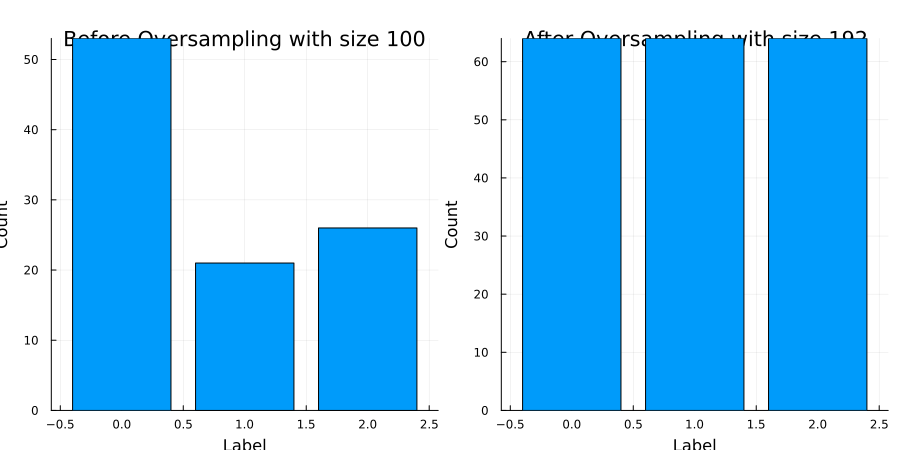

In [7]:
include("plot.jl")
plot_data(y, yover, X, Xover, hist_only=true)